### 要点
本篇教程是基于 Deep Q network (DQN) 的选学教程. 以下教程缩减了在 DQN 方面的介绍, 着重强调 Double DQN 和 DQN 在代码上不同的地方. 所以还没了解 DQN 的同学们, 有关于 DQN 的知识, 请从 这个视频 和 这个Python教程 开始学习.

接下来我们说说为什么会有 Double DQN 这种算法. 所以我们从 Double DQN 相对于 Natural DQN (传统 DQN) 的优势说起.

一句话概括, DQN 基于 Q-learning, Q-Learning 中有 Qmax, Qmax 会导致 Q现实 当中的过估计 (overestimate). 而 Double DQN 就是用来解决过估计的. 在实际问题中, 如果你输出你的 DQN 的 Q 值, 可能就会发现, Q 值都超级大. 这就是出现了 overestimate.

这次的 Double DQN 的算法基于的是 OpenAI Gym 中的 Pendulum 环境. 如果还不了解如何使用 OpenAI 的话, 这里有我的一个教程. 以下就是这次的结果, 先睹为快.

### Double DQN 算法
我们知道 DQN 的神经网络部分可以看成一个 最新的神经网络 + 老神经网络, 他们有相同的结构, 但内部的参数更新却有时差. 而它的 Q现实 部分是这样的:
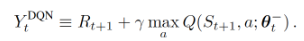
上图Q$\overline{\text{t}}$是老的神经网络参数（target_net），取出St+1状态具有最大Q值的action，输入到target_net，作为Q现实。

因为我们的神经网络预测 Qmax 本来就有误差, 每次也向着最大误差的 Q现实 改进神经网络, 就是因为这个 Qmax 导致了 overestimate. 所以 Double DQN 的想法就是引入另一个神经网络来打消一些最大误差的影响. 而 DQN 中本来就有两个神经网络, 我们何不利用一下这个地理优势呢. 所以, 我们用 Q估计 的神经网络估计 Q现实 中 Qmax(s', a') 的最大动作值. 然后用这个被 Q估计 估计出来的动作来选择 Q现实 中的 Q(s'). 总结一下:

有两个神经网络: Q_eval (Q估计中的), Q_next (Q现实中的).

原本的 Q_next = max(Q_next(s', a_all)).

Double DQN 中的 Q_next = Q_next(s', argmax(Q_eval(s', a_all))). 也可以表达成下面那样.
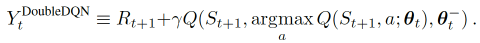
图θ$\overline{\text{t}}$是老的神经网络参数（target_net），θt是最新的神经网络参数，Q函数是神经网络输出的Q值。

### 更新方法
好了, 有了理论, 我们就来用 Python 实现它吧.

这里的代码都是基于之前 DQN 教程中的代码 (github), 在 RL_brain 中, 我们将 class 的名字改成 DoubleDQN, 为了对比 Natural DQN, 我们也保留原来大部分的 DQN 的代码. 我们在 __init__ 中加一个 double_q 参数来表示使用的是 Natural DQN 还是 Double DQN. 为了对比的需要, 我们的 tf.Session() 也单独传入. 并移除原本在 DQN 代码中的这一句:

self.sess.run(tf.global_variables_initializer())

In [1]:
class DoubleDQN:
    def __init__(..., double_q=True, sess=None):
        ...
        self.double_q = double_q
        if sess is None:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
        else:
            self.sess = sess
        ...

SyntaxError: invalid syntax (<ipython-input-1-b5f5b9d98869>, line 2)

接着我们来修改 learn() 中的代码. 我们对比 Double DQN 和 Natural DQN 在 tensorboard 中的图, 发现他们的结构并没有不同, 但是在计算 q_target 的时候, 方法是不同的.
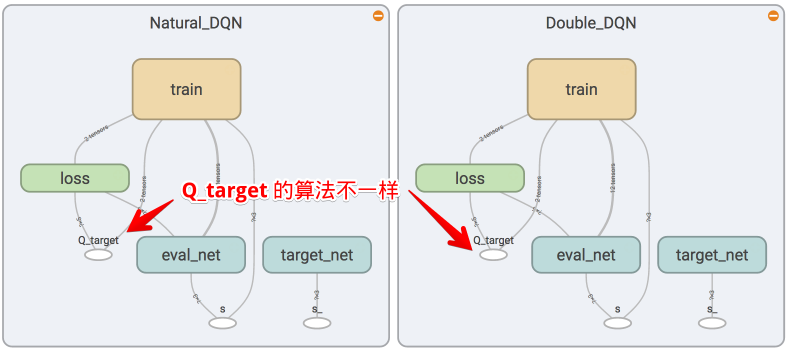

In [6]:
"""
The double DQN based on this paper: https://arxiv.org/abs/1509.06461
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
Tensorflow: 1.0
gym: 0.8.0
"""

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


class DoubleDQN:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.005,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=200,
            memory_size=3000,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
            double_q=True, #标识是double DQN还是普通DQN
            sess=None,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        self.double_q = double_q    # decide to use double q or not

        self.learn_step_counter = 0
        self.memory = np.zeros((self.memory_size, n_features*2+2))
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        if sess is None:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())
        else:
            self.sess = sess
        if output_graph:
            tf.summary.FileWriter("logs/", self.sess.graph)
        self.cost_his = []

    def _build_net(self): #和普通DQN方法一样（和变量 double_q 没有关系）
        def build_layers(s, c_names, n_l1, w_initializer, b_initializer):
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [self.n_features, n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1, n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(tf.matmul(s, w1) + b1)

            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                out = tf.matmul(l1, w2) + b2
            return out
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None, self.n_features], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss

        with tf.variable_scope('eval_net'):
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 20, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            self.q_eval = build_layers(self.s, c_names, n_l1, w_initializer, b_initializer)

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None, self.n_features], name='s_')    # input
        with tf.variable_scope('target_net'):
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            self.q_next = build_layers(self.s_, c_names, n_l1, w_initializer, b_initializer)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # 这一段和 DQN 一样:
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)
            print('\ntarget_params_replaced\n')

        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        # 这一段和 DQN 不一样（计算Q_target不一样）
        q_next, q_eval4next = self.sess.run(
            # q_next 对应公式的θt⎯ ，老的神经网络；q_eval对应公式中的θt，是最新的神经网络
            # 它们的输入都是next_state（St+1）
            [self.q_next, self.q_eval],
            feed_dict={self.s_: batch_memory[:, -self.n_features:],    # next observation
                       self.s: batch_memory[:, -self.n_features:]})    # next observation
        #Q估计：输入状态是 state（St），并使用self.q_eval（eval_net）计算，注意 self.q_eval是网络，q_eval是Q估计，不同的变量
        q_eval = self.sess.run(self.q_eval, {self.s: batch_memory[:, :self.n_features]}) #observation
        q_target = q_eval.copy()
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, self.n_features + 1]

        if self.double_q:   # 如果是 Double DQN
            max_act4next = np.argmax(q_eval4next, axis=1)        # q_eval 得出的最高奖励动作
            selected_q_next = q_next[batch_index, max_act4next]  # Double DQN 选择 q_next 依据 q_eval 选出的动作
        else:       # 如果是 Natural DQN
            selected_q_next = np.max(q_next, axis=1)    # natural DQN

        q_target[batch_index, eval_act_index] = reward + self.gamma * selected_q_next


        # 这下面和 DQN 一样:
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, :self.n_features],
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    # 为了记录下我们选择动作时的 Q 值, 接下来我们就修改 choose_action() 功能, 让它记录下每次选择的 Q 值.
    def choose_action(self, observation):
        observation = observation[np.newaxis, :]
        actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
        action = np.argmax(actions_value)

        if not hasattr(self, 'q'):  # 记录选的 Qmax 值
            self.q = []
            self.running_q = 0
        self.running_q = self.running_q*0.99 + 0.01 * np.max(actions_value)
        self.q.append(self.running_q)

        if np.random.uniform() > self.epsilon:  # 随机选动作
            action = np.random.randint(0, self.n_actions)
        return action

### 对比结果
接着我们就来对比 Natural DQN 和 Double DQN 带来的不同结果啦. 代码在这

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

env = gym.make('Pendulum-v0')
env.seed(1) # 可重复实验
MEMORY_SIZE = 3000
ACTION_SPACE = 11    # 将原本的连续动作分离成 11 个动作

#env = env.unwrapped # 不做这个会有很多限制

print("action_space" + str(env.action_space)) # 查看这个环境中可用的 action 有多少个
print("observation_space" + str(env.observation_space))    # 查看这个环境中可用的 state 的 observation 有多少个
print("observation_space.high" + str(env.observation_space.high))   # 查看 observation 最高取值
print("observation_space.low" + str(env.observation_space.low))    # 查看 observation 最低取值

sess = tf.Session()
with tf.variable_scope('Natural_DQN'):
    natural_DQN = DoubleDQN(
        n_actions=ACTION_SPACE, n_features=3, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.001, double_q=False, sess=sess
    )

with tf.variable_scope('Double_DQN'):
    double_DQN = DoubleDQN(
        n_actions=ACTION_SPACE, n_features=3, memory_size=MEMORY_SIZE,
        e_greedy_increment=0.001, double_q=True, sess=sess, output_graph=True)

sess.run(tf.global_variables_initializer())


def train(RL):
    total_steps = 0
    observation = env.reset()
    while True:
        # if total_steps - MEMORY_SIZE > 8000: env.render()

        action = RL.choose_action(observation)

        f_action = (action-(ACTION_SPACE-1)/2)/((ACTION_SPACE-1)/4)   # 在 [-2 ~ 2] 内离散化动作

        observation_, reward, done, info = env.step(np.array([f_action]))

        reward /= 10     # normalize 到这个区间 (-1, 0). 立起来的时候 reward = 0.
        # 立起来以后的 Q target 会变成 0, 因为 Q_target = r + gamma * Qmax(s', a') = 0 + gamma * 0
        # 所以这个状态时的 Q 值大于 0 时, 就出现了 overestimate.

        RL.store_transition(observation, action, reward, observation_)

        if total_steps > MEMORY_SIZE:   # learning
            RL.learn()

        if total_steps - MEMORY_SIZE > 20000:   # stop game
            break

        observation = observation_
        total_steps += 1
    return RL.q # 返回所有动作 Q 值

# train 两个不同的 DQN
q_natural = train(natural_DQN)
q_double = train(double_DQN)

# 出对比图
plt.plot(np.array(q_natural), c='r', label='natural')
plt.plot(np.array(q_double), c='b', label='double')
plt.legend(loc='best')
plt.ylabel('Q eval')
plt.xlabel('training steps')
plt.grid()
plt.show()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
action_spaceBox(1,)
observation_spaceBox(3,)
observation_space.high[1. 1. 8.]
observation_space.low[-1. -1. -8.]


C:\Users\OS\Anaconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


ZeroDivisionError: division by zero